In [1]:
import h5py
import time
import warnings

# data processing
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 1. Load Datasets

In [2]:
with h5py.File('input/data/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])

with h5py.File('input/data/train/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])

with h5py.File('input/data/test/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])

with h5py.File('input/data/test/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])

In [3]:
data_train.shape

(30000, 784)

In [4]:
label_train.shape

(30000,)

In [5]:
data_test.shape

(10000, 784)

In [6]:
label_test.shape

(2000,)

In [7]:
X_train = data_train
y_train = label_train

X_test = data_test[:2000]
y_test = label_test

## 2. Data Preprocessing

In this section, it contains two modules, one is splitting datasets into training and validation datasets, and the other is utilizing PCA to reduce dimension.

### 2.1 training, validation datasets - split

In [8]:
"""
Splitting dataset into training and validation these two datasets.

Parameters:
    X - The original dataset
    y - The labels of dataset
    valid_ratio - The percentage of validation dataset, the value should be in (0, 1).
"""

def train_validate_split(X, y, valid_ratio):
    if (valid_ratio > 1) or (valid_ratio < 0):
        raise ValueError("The ratio of validation dataset must be between 0 and 1.")
    
    shuffled_idx = np.random.permutation(len(data_train))
    
    train_len = int(len(shuffled_idx) * (1- valid_ratio))
    
    train_idx = shuffled_idx[:train_len]
    valid_idx = shuffled_idx[train_len:]
    
    return X[train_idx], X[valid_idx], y[train_idx], y[valid_idx]  

In [9]:
X_train, X_valid, y_train, y_valid = train_validate_split(data_train, label_train, 0.2)

X_test = data_test[:2000]
y_test = label_test

print("X_train.shape", X_train.shape)
print("y_train.shape", y_train.shape)

print("X_valid.shape", X_valid.shape)
print("y_valid.shape", y_valid.shape)

print("X_test.shape", X_test.shape)
print("y_test.shape", y_test.shape)

X_train.shape (24000, 784)
y_train.shape (24000,)
X_valid.shape (6000, 784)
y_valid.shape (6000,)
X_test.shape (2000, 784)
y_test.shape (2000,)


### 2.2 PCA - Dimension Reduction

In [10]:
from PCA import PCA

"""
Create PCA class directly.

Parameters:
    n_components - The dimention after applying PCA.
"""

pca = PCA(90)
pca.fit(X_train)

PCA(n_components = 90)

In [11]:
## Decomposition

X_train_reduction = pca.transform(X_train)
X_valid_reduction = pca.transform(X_valid)
X_test_reduction = pca.transform(X_test)

print("X_train_reduction.shape", X_train_reduction.shape)
print("X_valid_reduction.shape", X_valid_reduction.shape)
print("X_test_reduction.shape", X_test_reduction.shape)

X_train_reduction.shape (24000, 90)
X_valid_reduction.shape (6000, 90)
X_test_reduction.shape (2000, 90)


In [12]:
def calc_similarity(X, X_inv):
    return 1 - np.sum((X-X_inv)**2)/np.sum(X**2)

In [13]:
X_train_redinv = pca.inverse_transform(X_train_reduction)

In [14]:
calc_similarity(X_train, X_train_redinv)

0.9595884268888623

## 3. Model - LogisticRegression

Since LogisticRegression can do binary classification task only, I import and compare the performance of applying OneVsRestClassifier and OneVsOneClassifier to implement multiclass classification respectively.

In [15]:
from LogisticRegression import LogisticRegression

### 3.1 OneVsRestClassifier

In [16]:
%%time
from OneVsRestClassifier import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(LogisticRegression())
ovr_clf.fit(X_train_reduction, y_train)

CPU times: user 21min 25s, sys: 20.5 s, total: 21min 45s
Wall time: 12min 13s


OneVsRestClassifier()

In [17]:
%%time

y_pred_valid_ovr = ovr_clf.predict(X_valid_reduction)

CPU times: user 1.09 s, sys: 12.8 ms, total: 1.1 s
Wall time: 943 ms


In [18]:
%%time

y_pred_test_ovr = ovr_clf.predict(X_test_reduction)

CPU times: user 306 ms, sys: 4.33 ms, total: 311 ms
Wall time: 309 ms


### 3.3 OneVsOneClassifier

In [19]:
%%time

from OneVsOneClassifier import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(LogisticRegression())
ovo_clf.fit(X_train_reduction, y_train)

CPU times: user 16min 57s, sys: 15.3 s, total: 17min 12s
Wall time: 9min 17s


OneVsOneClassifier()

In [20]:
%%time

y_pred_valid_ovo = ovo_clf.predict(X_valid_reduction)

CPU times: user 10.3 s, sys: 28.4 ms, total: 10.3 s
Wall time: 10.1 s


In [21]:
%%time

y_pred_test_ovo = ovo_clf.predict(X_test_reduction)

CPU times: user 3.37 s, sys: 12 ms, total: 3.38 s
Wall time: 3.39 s


## 4. Metrics

In this section, it will show the performance of model through accuracy, confusion matrix, precision, recall and F1 score.

### 4.1 accuracy_score

In [22]:
from metrics import accuracy_score

## validation dataset
print("OvR", accuracy_score(y_valid, y_pred_valid_ovr))
print("OvO", accuracy_score(y_valid, y_pred_valid_ovo))

OvR 0.8083333333333333
OvO 0.842


In [23]:
## test dataset
print("OvR", accuracy_score(y_test, y_pred_test_ovr))
print("OvO", accuracy_score(y_test, y_pred_test_ovo))

OvR 0.811
OvO 0.8305


### 4.2 confusion_matrix

In [24]:
from metrics import confusion_matrix

def plot_confusion_matrix(data, title):
    sns.set_style("whitegrid")
    plt.figure(figsize=(8, 5))

    ax = sns.heatmap(data, annot=True, fmt="d", cmap="YlGnBu")
    plt.title("Confusion Matrix - " + title, fontsize="14")
    plt.xlabel("Actual", fontsize="12")
    plt.ylabel("Predict", fontsize="12")
    plt.show()

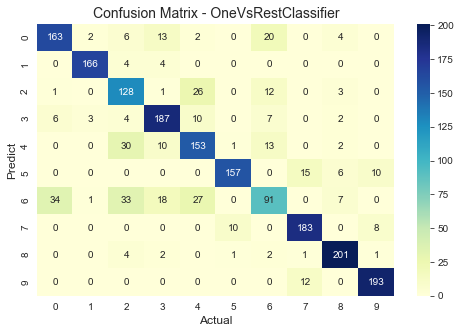

In [25]:
# OneVsRestClassifier
cm_ovr = confusion_matrix(y_test, y_pred_test_ovr)

plot_confusion_matrix(cm_ovr, "OneVsRestClassifier")

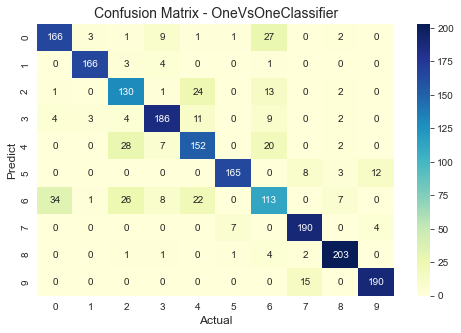

In [26]:
# OneVsOneClassifier
cm_ovo = confusion_matrix(y_test, y_pred_test_ovo)

plot_confusion_matrix(cm_ovo, "OneVsOneClassifier")

### 4.3 precision & recall

In [27]:
from metrics import precision, recall

cm_precision_ovo = precision(y_test, y_pred_test_ovo)
cm_precision_ovo

col_0
0    0.809756
1    0.959538
2    0.673575
3    0.861111
4    0.723810
5    0.948276
6    0.604278
7    0.883721
8    0.918552
9    0.922330
dtype: float64

In [28]:
cm_recall_ovo = recall(y_test, y_pred_test_ovo)
cm_recall_ovo

row_0
0    0.790476
1    0.954023
2    0.760234
3    0.849315
4    0.727273
5    0.877660
6    0.535545
7    0.945274
8    0.957547
9    0.926829
dtype: float64

### 4.4 F1 score

In [29]:
from metrics import f1_score

F1_ovr = f1_score(y_test, y_pred_test_ovr)
F1_ovr

col_0
0    0.787440
1    0.959538
2    0.673684
3    0.823789
4    0.716628
5    0.879552
6    0.511236
7    0.888350
8    0.919908
9    0.925659
dtype: float64

In [30]:
F1_ovo = f1_score(y_test, y_pred_test_ovo)
F1_ovo

col_0
0    0.800000
1    0.956772
2    0.714286
3    0.855172
4    0.725537
5    0.911602
6    0.567839
7    0.913462
8    0.937644
9    0.924574
dtype: float64